# Keras 
 - 前走のデータを使った予測モデル
 - 3着までを1、それ以外を0とした2値分類

In [1]:
import numpy as np
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split,StratifiedKFold,KFold
from sklearn.preprocessing import StandardScaler

from sklearn import metrics

from keras.models import Sequential
from keras.layers import Dense
import tensorflow as tf

#GPUメモリの制御
physical_devices = tf.config.experimental.list_physical_devices('GPU')
if len(physical_devices) > 0:
    for k in range(len(physical_devices)):
        tf.config.experimental.set_memory_growth(physical_devices[k], True)
        print('memory growth:', tf.config.experimental.get_memory_growth(physical_devices[k]))
else:
    print("Not enough GPU hardware devices available")


Using TensorFlow backend.


'\nphysical_devices = tf.config.experimental.list_physical_devices(\'GPU\')\nif len(physical_devices) > 0:\n    for k in range(len(physical_devices)):\n        tf.config.experimental.set_memory_growth(physical_devices[k], True)\n        print(\'memory growth:\', tf.config.experimental.get_memory_growth(physical_devices[k]))\nelse:\n    print("Not enough GPU hardware devices available")\n'

In [2]:
#データの読み込み
df = pd.read_csv("../../data/baseline_data.csv")
df_past1 = df[(df["past_race_num"]==1)]

In [3]:
#最低限の前処理
df_past1 = df_past1.fillna({'past_dif_time1': 0, 'past_dif_time2': 0})
df_past1 = df_past1.dropna(how='any')
columns = ["pred_horse_sex",
          "pred_race_rank1",
          "pred_race_rank2",
          "pred_kind",
          "pred_distance",
          "pred_condition",
          "pred_place",
          "past_horse_sex",
          "past_race_rank1",
          "past_race_rank2",
          "past_distance",
          "past_kind",
          "past_condition",
          "past_place"]
df_past1 = pd.get_dummies(df_past1, drop_first=True, columns=columns)
#target
df_past1["target"] = df_past1.pred_tyaku.apply(lambda x : 1 if x < 4 else 0)



In [4]:
learn_data = df_past1.sample(frac=1,random_state=1)
scaler = StandardScaler()

X          = learn_data.iloc[:,4:-1].values
X          = scaler.fit_transform(X)
y          = learn_data.target.values
x_columns  = learn_data.iloc[:,4:-1].columns

X_train,X_test,y_train,y_test = train_test_split(X,y,train_size=0.8,stratify=y,random_state=1)

In [5]:
#model
def create_model(optimizer='adam',init = 'glorot_normal',input_dim=None):
    model= Sequential()
    model.add(Dense(128,input_dim=input_dim,kernel_initializer=init,activation='relu'))
    model.add(Dense(256,kernel_initializer=init,activation='relu'))
    model.add(Dense(128,kernel_initializer=init,activation='relu'))
    model.add(Dense(64,kernel_initializer=init,activation='relu'))
    model.add(Dense(1, kernel_initializer=init,activation='sigmoid'))
    model.compile(loss='binary_crossentropy',optimizer=optimizer,metrics=['accuracy'])
    return model

In [6]:
model = create_model(input_dim = X.shape[1])

In [8]:
fit = model.fit(x=X_train,y=y_train,
         validation_data=(X_test,y_test),
         epochs=20,
         batch_size = 32,
         shuffle=True)

Train on 110475 samples, validate on 27619 samples
Epoch 1/20
110475/110475 [==============================] - 7s 63us/step - loss: 0.4738 - accuracy: 0.7848 - val_loss: 0.4629 - val_accuracy: 0.7880
Epoch 2/20
110475/110475 [==============================] - 7s 61us/step - loss: 0.4612 - accuracy: 0.7902 - val_loss: 0.4604 - val_accuracy: 0.7889
Epoch 3/20
110475/110475 [==============================] - 7s 62us/step - loss: 0.4566 - accuracy: 0.7928 - val_loss: 0.4605 - val_accuracy: 0.7903
Epoch 4/20
110475/110475 [==============================] - 7s 61us/step - loss: 0.4533 - accuracy: 0.7951 - val_loss: 0.4583 - val_accuracy: 0.7899
Epoch 5/20
110475/110475 [==============================] - 7s 61us/step - loss: 0.4495 - accuracy: 0.7968 - val_loss: 0.4599 - val_accuracy: 0.7892
Epoch 6/20
110475/110475 [==============================] - 7s 61us/step - loss: 0.4458 - accuracy: 0.7981 - val_loss: 0.4609 - val_accuracy: 0.7879
Epoch 7/20
110475/110475 [=============================

auc 0.6663063614910356


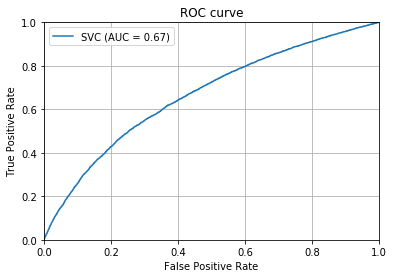

In [9]:
#auc
result_pred = model.predict(X_test)
auc = metrics.roc_auc_score(y_test, result_pred)
print("auc",auc)
fpr, tpr, thresholds = metrics.roc_curve(y_test, result_pred)
auc = metrics.auc(fpr, tpr)
plt.plot(fpr, tpr, label='SVC (AUC = %.2f)'%auc)
plt.legend()
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid(True)
plt.show()

train (epoch:20/loss:0.3268551815435557)
test  (epoch:20/loss:0.6408554666863011)


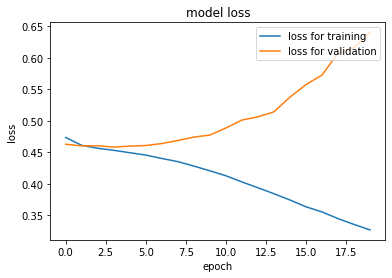

In [10]:
#loss
def loss_plot(train_loss,test_loss):
    print("train (epoch:{}/loss:{})" .format( str(len(train_loss)) , str(train_loss[-1])))
    print("test  (epoch:{}/loss:{})" .format( str(len(test_loss)) , str(test_loss[-1])))
    plt.figure()
    plt.plot(np.arange(0,len(train_loss)),train_loss,label="loss for training")
    plt.plot(np.arange(0,len(test_loss)),test_loss,label="loss for validation")

    plt.legend()
    plt.title('model loss')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(loc='upper right')
    plt.show()
#run
loss_plot(fit.history['loss'],fit.history['val_loss'])